In [33]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import confusion_matrix
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor, NeuralNetClassifier
import models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
import viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
df = data_tracks.get_data()
n = df.shape[0]

# make logistic data
# feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement']
# feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 'rise', 'fall']
# feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 
#               'rise', 'fall', 'X_std', 'X_min', 'X_mean', 'max_diff', 'min_diff']
scs = [f'sc_{i}' for i in range(12)]
feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 
              'rise', 'fall', 'X_std', 'X_min', 'X_mean', 'max_diff', 'min_diff'] + scs
X = df[feat_names]

# normalize and store
X_mean = X.mean()
X_std = X.std()
norms = {
    feat_names[i]: {'mu': X_mean[i], 'std': X_std[i]} for i in range(len(feat_names))
}
X = (X - X_mean) / X_std
y = df['y_thresh'].values


# split testing data based on cell num
idxs_test = df.cell_num.isin([6])
X_test, Y_test = X[idxs_test], y[idxs_test]
X_traces_test = df.X[idxs_test]

# compare all models

In [34]:
def load_results(out_dir):
    r = []
    for fname in os.listdir(out_dir):
        d = pkl.load(open(oj(out_dir, fname), 'rb'))
        metrics = {k: d['cv'][k] for k in d['cv'].keys() if not 'curve' in k}
        out = {k: np.mean(metrics[k]) for k in metrics}
        out.update({k + '_std': np.std(metrics[k]) for k in metrics})
        out['model_type'] = fname.replace('.pkl', '') #d['model_type']
        
        imp_mat = np.array(d['imps']['imps'])
        imp_mu = imp_mat.mean(axis=0)
        imp_sd = imp_mat.std(axis=0)
        
        feat_names = d['feat_names']
        out.update({feat_names[i] + '_f': imp_mu[i] for i in range(len(feat_names))})
        out.update({feat_names[i]+'_std_f': imp_sd[i] for i in range(len(feat_names))})
        r.append(pd.Series(out))
    r = pd.concat(r, axis=1).T.infer_objects()
    r = r.reindex(sorted(r.columns), axis=1) # sort the column names
    r = r.round(3)
    r = r.set_index('model_type')
    return r
out_dir = 'results/outcome=y_thresh'
results = load_results(out_dir)

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



**look at prediction metrics**

In [36]:
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values('accuracy', ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r.style.background_gradient(cmap='viridis', axis=0) # columns differently colored
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])

,accuracy,balanced_accuracy,f1,precision,recall,roc_auc
model_type,,,,,,
mlp2_11_none,0.676,0.659,0.768,0.859,0.707,0.71
mlp2_9_none,0.675,0.655,0.765,0.845,0.712,0.715
svm_23_none,0.673,0.661,0.771,0.879,0.699,0.614
svm_9_none,0.67,0.658,0.769,0.877,0.698,0.613
svm_11_none,0.668,0.652,0.767,0.873,0.697,0.61
logistic_4_none,0.667,0.664,0.766,0.873,0.703,0.7
svm_4_none,0.667,0.671,0.775,0.918,0.682,0.591
mlp2_4_none,0.664,0.65,0.764,0.871,0.695,0.707
rf_9_none,0.664,0.641,0.753,0.821,0.709,0.678


**look at feat importances**

In [79]:
r = results
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])
r = r.sort_values('accuracy', ascending=False)
keys = [k for k in r if '_f' in k]
keys_remapped = {k: k.replace('_f', '') for k in keys}
r = r[keys].rename(columns=keys_remapped)
# r = r.sort_values('lifetime')
r = r[r.index.str.contains('23')]


# r = r[r2.index.str.contains('11')]
# r = r[r2.index.str.contains('ros')]
r = r[r.index.str.contains('none')]
r = r[[k for k in r if not 'std' in k]]
r = r.rank(axis=1, ascending=False)
# r.mean()

r = r.reindex(r.mean().sort_values(ascending=True).index, axis=1) # sort cols by mean rank
r.insert(0, 'acc', results.loc[idxs]['accuracy'])
# r2 = r2[feat_names[:6]]

subset = list(r.keys())
subset.remove('acc')
r.fillna(0).style.background_gradient(cmap='viridis_r', axis=1, subset=subset) # rows differently colored

,acc,lifetime,fall,sc_0,rise,min_diff,max_diff,sc_6,mean_square_displacement,sc_8,sc_3,X_min,sc_2,total_displacement,sc_9,sc_4,sc_1,X_mean,X_max,sc_11,sc_10,sc_5,sc_7
model_type,,,,,,,,,,,,,,,,,,,,,,,
svm_23_none,0.673,2,2,2,6,13.5,6,4,17,22,11,8.5,17,17,6,20,13.5,11,8.5,21,17,11,17
rf_23_none,0.656,3.5,1,5.5,2,10.5,10.5,16,3.5,12,17,5.5,13,9,14.5,14.5,19,7.5,7.5,22,18,20,21
logistic_23_none,0.654,2,12,7,10,11,9,17,14,1,3,15.5,4,13,21,5,8,22,15.5,6,18,19,20
mlp2_23_none,0.642,1,2,7.5,17.5,9.5,19.5,5.5,9.5,5.5,12,22,14.5,17.5,3.5,21,7.5,14.5,19.5,11,3.5,14.5,14.5
gb_23_none,0.642,3,1,2,6.5,6.5,13,10.5,19,16,6.5,10.5,16,13,20,4,16,21,22,6.5,18,9,13
dt_23_none,0.563,2,1,15.5,4,7,5,12,3,10,18,9,11,6,13,14,19,8,15.5,22,17,20.5,20.5


# analyze individual model

metric                   	validation
balanced_accuracy        	0.810 ~ 0.030
accuracy                 	0.889 ~ 0.017
precision                	0.776 ~ 0.089
recall                   	0.677 ~ 0.093
f1                       	0.712 ~ 0.028
roc_auc                  	0.950 ~ 0.004

feature importances
X_max                    	0.061 ~ 0.005
lifetime                 	0.356 ~ 0.028
total_displacement       	0.035 ~ 0.002
mean_square_displacement 	0.070 ~ 0.006
rise                     	0.141 ~ 0.013
fall                     	0.110 ~ 0.013
X_std                    	0.045 ~ 0.004
X_min                    	0.067 ~ 0.015
X_mean                   	0.033 ~ 0.001
max_diff                 	0.037 ~ 0.004
min_diff                 	0.045 ~ 0.001


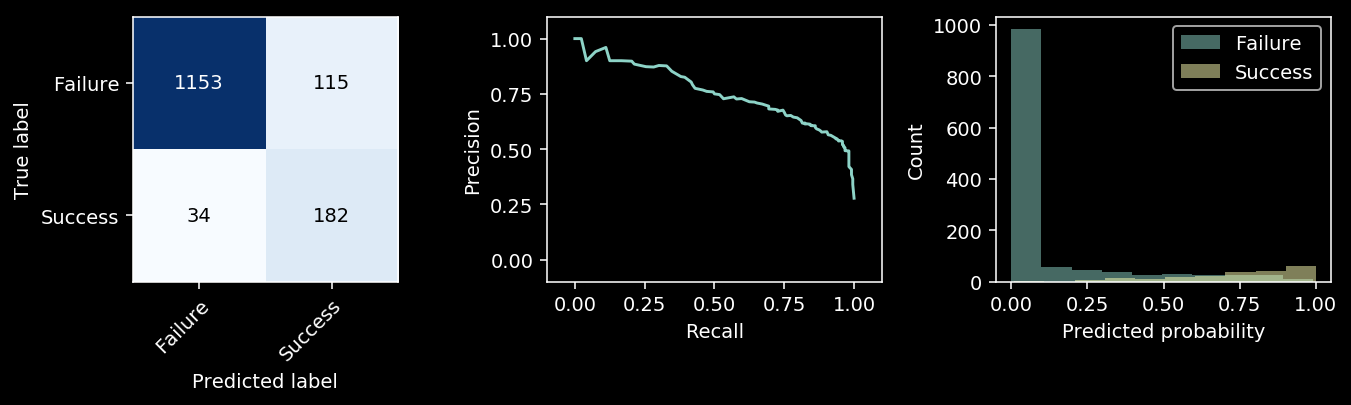

In [10]:
def visualize_individual_results(results):
    scores_cv = results['cv']
    scores_test = results['test']
    imps = results['imps']
    m = imps['model'][0]
    print(Fore.CYAN + f'{"metric":<25}\tvalidation') #\ttest')
    for s in results['metrics']:
        if not 'curve' in s:
            print(Fore.WHITE + f'{s:<25}\t{np.mean(scores_cv[s]):.3f} ~ {np.std(scores_cv[s]):.3f}')
    #         print(Fore.WHITE + f'{s:<25}\t{np.mean(scores_cv[s]):.3f} ~ {np.std(scores_cv[s]):.3f}\t{np.mean(scores_test[s]):.3f} ~ {np.std(scores_test[s]):.3f}')

    print(Fore.CYAN + '\nfeature importances')
    imp_mat = np.array(imps['imps'])
    imp_mu = imp_mat.mean(axis=0)
    imp_sd = imp_mat.std(axis=0)
    for i, feat_name in enumerate(results['feat_names']):
        print(Fore.WHITE + f'{feat_name:<25}\t{imp_mu[i]:.3f} ~ {imp_sd[i]:.3f}')

    # print(m.coef_)
    plt.figure(figsize=(10, 3), dpi=140)
    R, C = 1, 3
    plt.subplot(R, C, 1)
    # print(X_test.shape, results['feat_names'])
    preds = m.predict(X_test[results['feat_names']])
    preds_proba = m.predict_proba(X_test[results['feat_names']])[:, 1]    
    viz.plot_confusion_matrix(Y_test, preds, classes=np.array(['Failure', 'Success']))

    plt.subplot(R, C, 2)
    prec, rec, thresh = scores_test['precision_recall_curve'][0]
    plt.plot(rec, prec)
    plt.xlim((-0.1, 1.1))
    plt.ylim((-0.1, 1.1))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    
    
    plt.subplot(R, C, 3)
    plt.hist(preds_proba[Y_test==0], alpha=0.5, label='Failure')
    plt.hist(preds_proba[Y_test==1], alpha=0.5, label='Success')
    plt.xlabel('Predicted probability')
    plt.ylabel('Count')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return preds, preds_proba

# results = pkl.load(open('results/classify_outcome=y_consec_sig/rf_ros_11.pkl', 'rb'))
results = pkl.load(open('results/classify_outcome=y_thresh/rf_ros_11.pkl', 'rb'))
preds, preds_proba = visualize_individual_results(results)

In [ ]:
# visualize biggest errs
def viz_biggest_errs(X_traces_test, Y_test, preds, preds_proba):
    print(preds_proba.shape, X_traces_test.shape)
    residuals = np.abs(Y_test - preds_proba)
    
    
    R, C = 4, 5
    args = np.argsort(residuals)[::-1][:R * C]
    print(Y_test[args])
    print(preds[args])
    print(residuals[args][:10])
    plt.figure(figsize=(C * 3, R * 2.5))
    i = 0
    for r in range(R):
        for c in range(C):
            plt.subplot(R, C, i + 1)
            plt.plot(X_traces_test.iloc[args[i]], color='orange' if Y_test[i] else 'blue')
            i += 1
    plt.tight_layout()
    
# visualize biggest errs
def viz_errs_spatially(df, idxs_test, preds, Y_test):
    x_pos = df['x_pos'][idxs_test]
    y_pos = df['y_pos'][idxs_test]
    
    plt.figure(dpi=200)
    correct = preds==Y_test
    plt.plot(x_pos[correct], y_pos[correct], 'o', alpha=0.5, label='correct')
    plt.plot(x_pos[~correct], y_pos[~correct], 'x', color='red', alpha=0.5, label='err')    
    plt.legend()
#     plt.scatter(x_pos, y_pos, c=preds==Y_test, alpha=0.5)
    plt.xlabel('x position')
    plt.ylabel('y position')
    '''
    print(preds_proba.shape, X_traces_test.shape)
    residuals = np.abs(Y_test - preds_proba)
    
    
    R, C = 4, 5
    args = np.argsort(residuals)[::-1][:R * C]
    print(Y_test[args])
    print(preds[args])
    print(residuals[args][:10])
    plt.figure(figsize=(C * 3, R * 2.5))
    i = 0
    for r in range(R):
        for c in range(C):
            plt.subplot(R, C, i + 1)
            plt.plot(X_traces_test.iloc[args[i]], color='orange' if Y_test[i] else 'blue')
            i += 1
    '''
    plt.tight_layout()
    
# viz_biggest_errs(X_traces_test, Y_test, preds, preds_proba)    
viz_errs_spatially(df, idxs_test, preds_proba, Y_test)

**analyze dependence on lifetime**

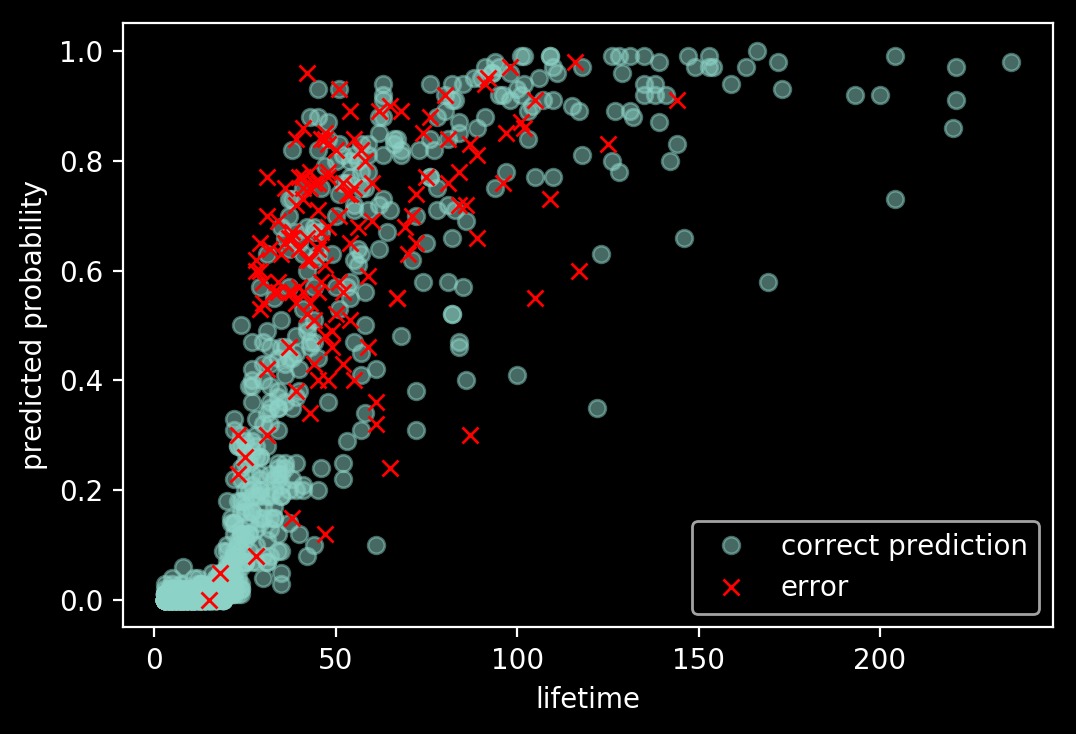

In [207]:
plt.figure(dpi=200)
correct_idxs = preds == Y_test
lifetime = X_test['lifetime'] * norms['lifetime']['std'] + norms['lifetime']['mu']
plt.plot(lifetime[correct_idxs], preds_proba[correct_idxs], 'o', alpha=0.5, label='correct prediction')
plt.plot(lifetime[~correct_idxs], preds_proba[~correct_idxs], 'x', color='red', label='error')
plt.xlabel('lifetime')
plt.ylabel('predicted probability')
plt.legend()
plt.show()